<a href="https://colab.research.google.com/github/grommy/CNN_in_TensorFlow/blob/master/week_4/Sign_language_TransferLearning_middle_cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import cv2

import matplotlib.pyplot as plt

The data for this exercise is available at: https://www.kaggle.com/datamunge/sign-language-mnist/home

Sign up and download to find 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv -- You will upload both of them using this button before you can continue.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/CNN_in_TF/Week4/sign-language-mnist

american_sign_language.PNG  amer_sign3.png	 sign_mnist_train.csv
amer_sign2.png		    sign_mnist_test.csv


In [0]:
!cp '/content/gdrive/My Drive/Colab Notebooks/CNN_in_TF/Week4/sign-language-mnist/sign_mnist_train.csv' .
!cp '/content/gdrive/My Drive/Colab Notebooks/CNN_in_TF/Week4/sign-language-mnist/sign_mnist_test.csv' .

In [5]:
import pandas as pd
X_train = pd.read_csv('sign_mnist_train.csv', nrows=100)
X_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [6]:
! ls

gdrive	sample_data  sign_mnist_test.csv  sign_mnist_train.csv


In [7]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
    images_list = []
    labels_list = []    
    with open(filename) as training_file:
      training_file.readline()
      print("working with %s" % filename)
      # Your code starts here
      for _, line in enumerate(training_file):
        row = [int(i) for i in line.split(',')]
        labels_list.append(row[0])
        images_list.append(row[1:785])
        
      images = np.reshape(images_list, (-1,28,28))
      labels = np.array(labels_list)
      
      # Your code ends here
    return images, labels


training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

working with sign_mnist_train.csv
working with sign_mnist_test.csv
(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [0]:
training_images_retyped = training_images.astype('uint8')


In [0]:
IMG_SIZE = 32
img_resized = cv2.resize(training_images_retyped[0], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

In [0]:
import imageio
imageio.imwrite('first_image.jpg', img_resized)

In [11]:
!ls

first_image.jpg  gdrive  sample_data  sign_mnist_test.csv  sign_mnist_train.csv


In [12]:
img_gray = np.expand_dims(training_images[0], 2)
img_gray.shape

(28, 28, 1)

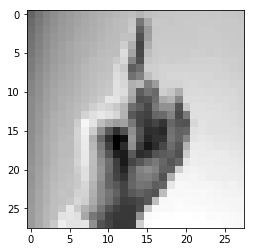

In [13]:
plt.imshow(training_images[0], cmap='gray');

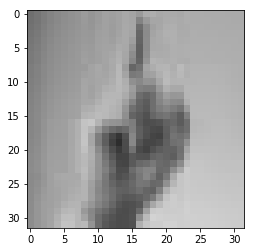

In [14]:
image = cv2.imread('first_image.jpg')
plt.imshow(image);

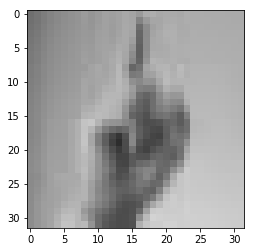

In [15]:
image_clr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_clr);

In [16]:
print(training_images[0].shape)
print(image.shape)
print(image_clr.shape)

(28, 28)
(32, 32, 3)
(32, 32, 3)


In [0]:
IMG_SIZE = 32

TRAIN_DATA_DIR = "/tmp/train_signs/"
VALIDATION_DATA_DIR = "/tmp/test_signs/"

In [18]:
!rm -r $TRAIN_DATA_DIR
!rm -r $VALIDATION_DATA_DIR

!mkdir $TRAIN_DATA_DIR
!mkdir $VALIDATION_DATA_DIR

rm: cannot remove '/tmp/train_signs/': No such file or directory
rm: cannot remove '/tmp/test_signs/': No such file or directory


In [19]:
def images_to_rgb(images_array, labels_array, save_dir, target_size):
  
  for label in np.unique(labels_array):
    label_dir = os.path.join(save_dir, str(label))
    try:
      os.stat(label_dir)
    except:
      os.mkdir(label_dir) 
    
  count = 0
  images_array_retyped = images_array.astype('uint8')
  for ar, label in zip(images_array_retyped, labels_array):
    img_resized = cv2.resize(ar, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
    filename = os.path.join(save_dir, str(label), "{}.jpg".format(str(count)))
    imageio.imwrite(filename, img_resized)
    count += 1
    
  # after done 
  print(count, "images")
  

training_images_rgb = images_to_rgb(training_images, training_labels, TRAIN_DATA_DIR, IMG_SIZE)
testing_images_rgb = images_to_rgb(testing_images, testing_labels, VALIDATION_DATA_DIR, IMG_SIZE)

27455 images
7172 images


In [20]:
print(len(os.listdir(TRAIN_DATA_DIR)))
print(len(os.listdir(VALIDATION_DATA_DIR)))

24
24


In [0]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)



In [22]:
BS = 32

train_data_iterator = \
  train_datagen.flow_from_directory(TRAIN_DATA_DIR, 
                                    target_size=(IMG_SIZE, IMG_SIZE),
                                    batch_size=BS,
                                    class_mode="categorical"
                                   )
validation_data_iterator = \
  validation_datagen.flow_from_directory(TRAIN_DATA_DIR, 
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=BS,
                                         class_mode="categorical"
                                        )

Found 27455 images belonging to 24 classes.
Found 27455 images belonging to 24 classes.


In [0]:
NUM_CLASSES = len(np.unique(training_labels))
print(NUM_CLASSES)

# training_labels_cat = tf.keras.utils.to_categorical(training_labels, dtype='int')
# testing_labels_cat = tf.keras.utils.to_categorical(testing_labels, dtype='int')
# print(training_labels_cat[0])
# print(testing_labels_cat[0])

## Use Transfer Learning

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751 <br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [26]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = "imagenet")
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# pre_trained_model.load_weights("imagenet")

W0718 08:15:16.928900 140558378395520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 7s 0us/step


In [0]:
# from tensorflow.keras.applications import ResNet50
# pre_trained_model = ResNet50(input_shape = (28, 28, 1), 
#                                 include_top = False, 
#                                 weights = None)

In [28]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, \
  GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential


def build_tl_model(original_model, num_classes, num_layer_to_drop=0, save_file=None):
  """
  Perform 'surgery' on a pretrained model. Then add layers to create a new model
  that has just one final, trainable layer with softmax activation for 
  multi-class output.
  """
  # ______________________________________________________________________________
  # Extract needed info from pre-trained model.
  bottleneck_input  = original_model.get_layer(index=0).input
  bottleneck_output = original_model.get_layer('mixed5').output
  bottleneck_model = Model(inputs=bottleneck_input, outputs=bottleneck_output)

  # ______________________________________________________________________________
  # Freeze these layers so we are not retraining the full model. 
  for layer in bottleneck_model.layers:
    layer.trainable = False

  # ______________________________________________________________________________
  # Build new transfer learning model.
  new_model = Sequential()
  new_model.add(bottleneck_model)
#   new_model.add(Conv2D(36, kernel_size=(3,3), activation='relu'))
  new_model.add(GlobalAveragePooling2D())
  new_model.add(Dense(128, activation="relu"))
  new_model.add(Dense(num_classes, activation="softmax"))

#   NUM_CLASSES = len(os.listdir(IMG_DIR))  # How many image classes are in our new data?
  BOTTLENECK_DIM = bottleneck_output.shape.dims[1]  # The number of nodes in the second to last layer of the pre-trained model.
  print(BOTTLENECK_DIM)                    

  if save_file:
    new_model.save(save_file)

  return new_model

In [44]:
transfer_model = build_tl_model(pre_trained_model, num_classes=NUM_CLASSES)
transfer_model.summary()

3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 3, 3, 768)         5138656   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               98432     
_________________________________________________________________
dense_7 (Dense)              (None, 24)                3096      
Total params: 5,240,184
Trainable params: 101,528
Non-trainable params: 5,138,656
_________________________________________________________________


In [0]:
# Compile Model. 
from tensorflow.keras.optimizers import RMSprop, Adam
transfer_model.compile(optimizer=RMSprop(lr=1e-2), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

transfer_checkpoint = ModelCheckpoint(filepath='transfer_model.h5',
                             monitor='val_acc', 
                             save_best_only=True, 
                             load_weights_on_restart=True,
                            )
transfer_earlystopping = EarlyStopping(monitor='val_acc',
                             patience=2)

In [47]:
BS = 64

transfer_train_data_iterator = \
  train_datagen.flow_from_directory(TRAIN_DATA_DIR, 
                                    target_size=(75, 75),
                                    batch_size=BS,
                                    class_mode="categorical"
                                   )
transfer_validation_data_iterator = \
  validation_datagen.flow_from_directory(TRAIN_DATA_DIR, 
                                         target_size=(75, 75),
                                         batch_size=BS,
                                         class_mode="categorical"
                                        )

Found 27455 images belonging to 24 classes.
Found 27455 images belonging to 24 classes.


In [49]:
# Train the Model
EPOCHS = 20

transfer_history = transfer_model.fit_generator(
     transfer_train_data_iterator,
	   validation_data=transfer_validation_data_iterator,
	   steps_per_epoch=len(training_images) // BS,
     epochs=EPOCHS,
     callbacks=[transfer_checkpoint, transfer_earlystopping]
)

Epoch 1/20
428/428 [==============================] - 128s 300ms/step - loss: 0.9318 - acc: 0.6881 - val_loss: 5.2742 - val_acc: 0.2853
Epoch 2/20
428/428 [==============================] - 127s 296ms/step - loss: 0.8405 - acc: 0.7176 - val_loss: 5.1409 - val_acc: 0.2818
Epoch 3/20
428/428 [==============================] - 199s 465ms/step - loss: 0.7717 - acc: 0.7437 - val_loss: 6.4026 - val_acc: 0.2924
Epoch 4/20
428/428 [==============================] - 203s 475ms/step - loss: 0.7494 - acc: 0.7544 - val_loss: 4.0921 - val_acc: 0.3879
Epoch 5/20
428/428 [==============================] - 198s 463ms/step - loss: 0.7272 - acc: 0.7632 - val_loss: 4.7368 - val_acc: 0.3367
Epoch 6/20
428/428 [==============================] - 198s 463ms/step - loss: 0.7190 - acc: 0.7687 - val_loss: 5.0588 - val_acc: 0.3674


In [50]:
transfer_model.evaluate_generator(transfer_train_data_iterator)
    
# The output from model.evaluate should be close to:
# [6.92426086682151, 0.56609035]

[5.051161848859631, 0.37064287]

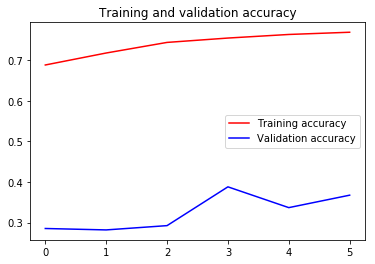

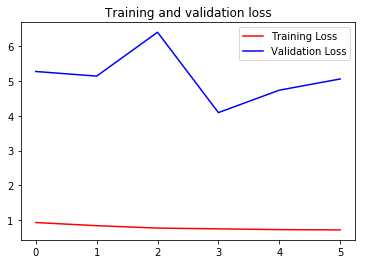

In [51]:
# Plot the chart for accuracy and loss on both training and validation
history = transfer_history

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Conclusion

Not the best approach for this task